# Fourier Part 2: Option pricing with Fourier-Cosine series expansion

This is an alternative approach way to Option pricing which is relatively easy to adapt and allows us to calculate the greeks. The Fourier-cosine series expansion produces a result which outputs the payoff of the instrument and the underlying process separately.

> See other related links
>* [Option pricing with Fourier transformation (Fourier Part 1)](<https://github.com/raghavduseja/Options/blob/da55f28ac27d95cf672364034035b510034191ff/Option%20pricing%20with%20Fourier%20transformation%20(Fourier%20Part%201).ipynb>)
>* Option pricing with Fourier-Cosine (Fourier Part 2)
>* Option pricing with Fast-Fourier-Transform (Fourier Part 3)

## Fourier-Cosine

### Cosine expansion

A function f(x) which is defined and integrable over interval [0, $\infty$]

$$ \frac{a_0}{2} + \sum_{n=1}^{\infty}  a_n cos(nx) $$

where $ a_n$ is defined as 

$$ \frac{2}{\pi} \int_{0}^{\pi} f(x) cos(nx)dx $$

### Transforming the variable

We can transform the variable x, so allow for some general vounds [b1,b2]

$$ x = {\pi}\frac{y-{b_1}}{b_2 -b_1}$$

By transforming the variable, we would have

$$ f(y) = \frac{a_0}{2} + \sum_{}^{} a_n cos (n{\pi}\frac{y-b_1}{b_2 -b_1}) $$

$$ \frac{2}{b_2 - b_1} \int_{b_1}^{b_2} f(y) cos(n{\pi}\frac{y-b_1}{b_2 - b_b1})dy $$

### General functions for valuation

We need to evaluate two specific functions $f(x) = e^x$ and $f(x) = 1$

We define

$$ v_n(c,d) = \int_c^d e^s cos(n{\pi}\frac{s-d_1}{b_2 - b_1})ds$$
and 
$$ {\psi_n}(c,d) = \int_c^d cos(n{\pi}\frac{s-d_1}{b_2 - b_1})ds$$

We can evaluate these two functions analytically 

$$ \upsilon_n (c,d) = \frac{cos(n \pi \frac{d-b_1}{b_2 - b_1} ) e^d - cos(n \pi \frac{c-b_1}{b_2 - b_1} ) e^c + \frac{n \pi}{b_2 - b_1}(sin(n \pi \frac{d-b_1}{b_2 - b_1} ) e^d - sin(n \pi \frac{c-b_1}{b_2 - b_1} ) e^c)}{1 + (\frac{n \pi}{b_2 - b_1})^2}$$

$$ \psi_n (c,d) = \begin{cases}
               \frac{b_2 - b_1}{n \pi}[sin(n \pi \frac{d - b_1}{b_2 - b_1}) - sin(n\pi \frac{c - b_1}{b_2 - b_1})] \text{ when n != 0}\\
                d-c \text{ when n = 0}\\
            \end{cases} $$

In [ ]:
def upsilon_n(b2, b1, d, c, n):
    npi_d = np.pi*n*(d-b1)/(b2-b1)
    npi_c = np.pi*n*(c-b1)/(b2-b1)
    val_one = (np.cos(npi_d)*np.exp(d)-np.cos(npi_c)*np.exp(c))
    val_two = (n*np.pi*(np.sin(npi_d)*np.exp(d)-np.sin(npi_c)*np.exp(c))/(b2-b1))
    return (val_one + val_two)/(1 + (n*np.pi/(b2-b1))**2)

def psi_n(b2, b1, d, c, n):
    if n == 0:
        return d-c
    else:
        return (b2-b1)*(np.sin(n*np.pi*(d-b1)/(b2-b1)) - np.sin(n*np.pi*(c-b1)/(b2-b1)))/(n*np.pi)

## Pricing

### Pricing a call under Black-Scholes

In [20]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# share 
r = 0.02
S0 = 100
sigma = 0.20

# call option 
K = 110
T = 1
k_log = np.log(K)

In [21]:
# code for the analytical solution for vanilla European call option pricing
d1_stock = (np.log(S0/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
d2_stock = d1_stock - sigma*np.sqrt(T)

analytic_callprice = S0*norm.cdf(d1_stock) - K*np.exp(-r*T)*norm.cdf(d2_stock) 
analytic_callprice

4.94386695723049

### Pricing a call under Fourier-Cosine

Under the transformation $ S_T = ln \frac{S_T}{K}$

$$c \approx e^{-rT}(\frac{\upsilon_0 \phi_{S_T}(0)}{2} + \Sigma_{n=1}^{N-1}Re(\phi_{S_T}(\frac{n \pi}{b_2 - b_1})e^{-in \pi \frac{b_1}{b_2 - b_1}})\upsilon_n)$$

The above formula is known as the COS formula.

where $\phi_{S_T} ()$ is the characterstic of $S_T$ and:

$$ \upsilon_n = \frac{2}{b_2 - b_1}K(\nu_n(0,b_2) - \psi_n(0,b_2)) $$

In [22]:
def v_n(K, b2, b1, n):
    return 2*K*(upsilon_n(b2, b1, b2, 0, n) - psi_n(b2, b1, b2, 0, n))/(b2 - b1)

# phi_ST
def logchar_func(u, S0, r, sigma, K, T):
    return np.exp(1j*u*(np.log(S0/K) + (r-sigma**2/2)*T) - (sigma**2)*T*(u**2)/2)

def call_price(N, S0, sigma, r, K, T, b2, b1):
    price = v_n(K, b2, b1, 0)*logchar_func(0, S0, r, sigma, K, T)/2
    for n in range(1,N):
        price = price + logchar_func(n*np.pi/(b2-b1), S0, r, sigma, K, T)*np.exp(-1j*n*np.pi*b1/(b2-b1))*v_n(K, b2, b1, n)
    return price.real*np.exp(-r*T)

This method was formulated by Fang and Oosterlee in 2008. <br>
You can find the link to the original publication in the **References** section below.

### Chosing an appropriate interval [b1,b2]

We need to choose appropriate values for b1 and b2 to use in the above formula. We are going to be intergrate over b1 and b2 instead of letting the integrals going to infinity.

$$ b_1 = c_1 - L \sqrt{c_2 + \sqrt{c_4}}$$

$$ b_2= c_1 + L \sqrt{c_2 + \sqrt{c_4}}$$

We are assuming that the underlying process follows the **Geometric Brownian Motion**, and under this assumption we can find the following values of L, c1, c2 and c4.

$$ L = 10 $$
$$ c_1 = \mu T$$
$$c_2 = \sigma_{S_T}T $$
$$c_4 = 0$$

In our case $c_1 = ln \frac{S_T}{K} + (r-\frac{\sigma^2}{2})T$ and $c_2 = \sigma^2 T$ for $S_T$.

In [23]:
c1 = r
c2 = T*sigma**2
c4 = 0
L = 10

b1 = c1 - L*np.sqrt(c2 - np.sqrt(c4))
b2 = c1 + L*np.sqrt(c2 - np.sqrt(c4))

### Calculating the Option price in Python

In [24]:
# Calculating COS for various N
COS_callprice = [None]*50

for i in range(1,51):
    COS_callprice[i-1] = call_price(i, S0, sigma, r, K, T, b2, b1)

In [29]:
COS_callprice[-1]

4.943866957230438

We can see that the COS prices converges to the Analytical Black-Scholes price as N increases. <br>
The final price is the same for both the methods.

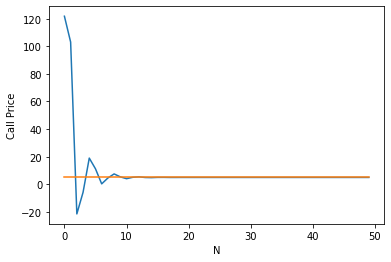

In [30]:
plt.plot(COS_callprice)
plt.plot([analytic_callprice]*50)
plt.xlabel("N")
plt.ylabel("Call Price")
plt.show()

We can now plot the "Log Absolute Error" between COS price and analytical price, as seen below:

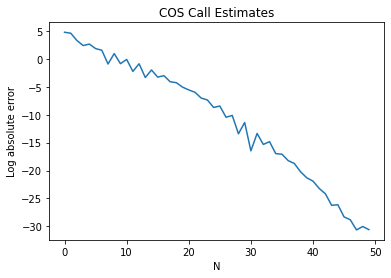

In [31]:
plt.plot(np.log(np.absolute(COS_callprice - analytic_callprice)))
plt.xlabel("N")
plt.ylabel("Log absolute error")
plt.title("COS Call Estimates")
plt.show()

### Related links
* [Option pricing with Fourier transformation (Fourier Part 1)](<https://github.com/raghavduseja/Options/blob/da55f28ac27d95cf672364034035b510034191ff/Option%20pricing%20with%20Fourier%20transformation%20(Fourier%20Part%201).ipynb>)
* Option pricing with Fourier-Cosine (Fourier Part 2)
* Option pricing with Fast-Fourier-Transform (Fourier Part 3)

### References

* Yves Hilpisch, "Chapter 6: Derivatives Analytics with Python: Data Analysis, Models, Simulation, Calibration and Hedging"
* Fourier methods, Python codes: https://github.com/yhilpisch/dawp/tree/master/python36/06_fou
* Martin Schmelzle, "COS Fourier-Cosine Series Expansions and Option Pricing", https://pfadintegral.com/articles/cos-option-pricing/
* Fang, Fang and Cornelis W. Oosterlee (2008) A novel pricing method for European options based on Fourier-cosine series expansions, SIAM Journal on Scientific Computing 31(2), 826–848. [DOI:10.1137/080718061](https://doi.org/10.1137/080718061)
* WQU notes, Computational Finance